THOMAS MCDONNELL QUANT TRADING STRATEGIES HW 2 ID = 12365628

In [939]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from datetime import datetime
from datetime import timedelta


import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

In [940]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key= 'uoxc6V3s61czWuHoGLcs')
    return qdata
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data


DATA

I decided to do two different pairs of ETF's as my last digit of my ID number, 8, had ETF pairs that were quite uncorrelated. I wanted to see the difference between this ETF pair and another one, so I chose my second to last ID number, 2 to also analyze to give me better results. 

In [941]:
PXJ = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': '2020-12-02', 'lte':  '2022-11-15'}, ticker='PXJ', api_key = 'uoxc6V3s61czWuHoGLcs' )
PXJ = PXJ.sort_index(ascending=False)
OIH = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': '2020-12-02', 'lte':  '2022-11-15'}, ticker='OIH', api_key = 'uoxc6V3s61czWuHoGLcs')
OIH = OIH.sort_index(ascending=False)
count = 0

for i in range(0,492):
    if (OIH['volume'][i]*OIH['adj_close'][i] > (PXJ['volume'][i]*PXJ['adj_close'][i])):
        count +=1
    else:
        hj = -1
count


492

This means that OIH is far more liquid than PXJ as it has a higher dollar volume in very trading day during this period.

Fama French 3 factor data over this given time period

In [942]:
ff = pd.read_csv('/Users/tmac/Library/Containers/com.microsoft.Excel/Data/Downloads/F-F_Research_Data_Factors_daily.CSV')
ff

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,20201202,0.11,-0.09,1.07,0.000
1,20201203,0.18,0.50,-0.09,0.000
2,20201204,1.02,1.47,0.84,0.000
3,20201207,0.03,0.24,-1.02,0.000
4,20201208,0.47,1.02,-0.71,0.000
...,...,...,...,...,...
488,20221109,-2.25,-0.62,0.55,0.014
489,20221110,5.68,1.66,-3.11,0.014
490,20221111,1.07,0.29,-1.08,0.014
491,20221114,-0.95,-0.39,0.26,0.014


EXCERCISE FOR PXJ x OIH

In [943]:
PXJ['date'] = pd.to_datetime(PXJ['date'])
OIH['date'] = pd.to_datetime(OIH['date'])


OIH = OIH.set_index('date')
PXJ = PXJ.set_index('date')

In [944]:
#X IS THE ETF WITH LESS DAILY VOLUME
#Y IS THE ETF WITH MORE DAILY VOLUME
def spread_reversion_strategy(X, Y, m, g, j, s):
    PNL_OT = pd.DataFrame(columns = ['Date', 'PNL by Date'])
    pnl = 0
    position_X = None
    position_Y = None
    open_X = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
    open_Y = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])

    Nt = (X['volume']*X['adj_close']).rolling(15).median()
    K =Nt.max()*2


    prices_X = X[['adj_close']]
    prices_Y = Y[['adj_close']]   
    for i in range(21, len(prices_X)):
        if prices_X.index[i].day == 1 or (prices_X.index[i].day == 2 and prices_X.index[i-1].day > 2) or (prices_X.index[i].day == 3 and prices_X.index[i-1].day > 3) or (prices_X.index[i].day == 4 and prices_X.index[i-1].day > 4):
            #CLOSE OUT OF PREV MONTH
            if len(open_X) > 0:
                if open_X['Position'][0] == 'Short':
                    pnl += (open_X['Shares'][0]*open_X['Price'][0] - open_X['Shares'][0]*prices_X['adj_close'][i-1])
                 
                elif open_X['Position'][0] == 'Long':
                    pnl += (open_X['Shares'][0]*prices_X['adj_close'][i-1] - open_X['Shares'][0]*open_X['Price'][0])
            if len(open_Y) > 0:
                if open_Y['Position'][0] == 'Short':
                    pnl += (open_Y['Shares'][0]*open_Y['Price'][0] - open_Y['Shares'][0]*prices_Y['adj_close'][i-1])
                
                elif open_Y['Position'][0] == 'Long':
                    pnl += (open_Y['Shares'][0]*prices_Y['adj_close'][i-1] - open_Y['Shares'][0]*open_Y['Price'][0])
                    
                PNL_OT = PNL_OT.append({'Date':prices_X.index[i-1], "PNL by Date": pnl}, ignore_index=True)
                pnl = 0
                continue
                
            open_X = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
            open_Y = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
            position_X = None
            position_Y = None

        #STOP LOSS
        if len(open_X) >0 and len(open_Y) > 0:
            gross = (open_X['Shares'][0]*open_X['Price'][0] + open_Y['Shares'][0]*open_Y['Price'][0])
            current = (open_X['Shares'][0]*prices_X['adj_close'][i] + open_Y['Shares'][0]*prices_Y['adj_close'][i])
            if current < s*gross:
                print('stop loss at ' + str(prices_X.index[i]))
                if open_X['Position'][0] == 'Short':
                    pnl += (open_X['Shares'][0]*open_X['Price'][0] - open_X['Shares'][0]*prices_X['adj_close'][i])
                    pnl += (open_Y['Shares'][0]*prices_Y['adj_close'][i] - open_Y['Shares'][0]*open_Y['Price'][0])
                elif open_X['Position'][0] == 'Long':
                    pnl += (open_X['Shares'][0]*prices_X['adj_close'][i] - open_X['Shares'][0]*open_X['Price'][0])
                    pnl += (open_Y['Shares'][0]*open_Y['Price'][0] - open_Y['Shares'][0]*prices_Y['adj_close'][i])
                open_X = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                open_Y = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                position_X = None
                position_Y = None

                PNL_OT = PNL_OT.append({'Date':prices_X.index[i], "PNL by Date": pnl}, ignore_index=True)
                pnl = 0
                continue
      
        X_returns = (prices_X['adj_close'][i] - prices_X['adj_close'][i-m]) / prices_X['adj_close'][i-m]
        Y_returns = (prices_Y['adj_close'][i] - prices_Y['adj_close'][i-m]) / prices_Y['adj_close'][i-m]
        z = X_returns = Y_returns
        if z > g:
            money = Nt[i]//100
            shares_X = money // prices_X['adj_close'][i]
            shares_Y = money//prices_Y['adj_close'][i]
        
            if position_X == 'Short':
                pass
            elif position_X == 'Long':
                pnl += (open_X['Shares'][0]*prices_X['adj_close'][i] - open_X['Shares'][0]*open_X['Price'][0])
            
            
                open_X = open_X = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                position_X = None
    
            else:
                open_X = open_X.append({"Date": X.index[i], "Position": "Short", "Shares": shares_X, "Price": X['adj_close'][i]}, ignore_index=True)
                position_X = "Short"

            if position_Y == 'Long':
                pass
        
                
            elif position_Y == 'Short':
                pnl += (open_Y['Shares'][0]*open_Y['Price'][0] - open_Y['Shares'][0]*prices_Y['adj_close'][i])
               
            
                open_Y = open_Y = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                position_Y = None
            else:
                open_Y = open_Y.append({"Date": X.index[i], "Position": "Long", "Shares": shares_Y, "Price": Y['adj_close'][i]}, ignore_index=True)
                position_Y = "Long"
                
                
        elif z < j:
            money = Nt[i]//100
            shares_X = money// prices_X['adj_close'][i]
            shares_Y = money//prices_Y['adj_close'][i]
        

            if position_Y == 'Short':
                pass
            elif position_Y == 'Long':
            
                pnl += (open_Y['Shares'][0]*prices_Y['adj_close'][i] - open_Y['Shares'][0]*open_Y['Price'][0])
        
            
                open_Y = open_Y = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                position_Y = None
            
            else:
                open_Y = open_Y.append({"Date": Y.index[i], "Position": "Short", "Shares": shares_Y, "Price": Y['adj_close'][i]}, ignore_index=True)
                position_Y = "Short"

            if position_X == 'Long':
                pass
            elif position_X == 'Short':
                pnl += (open_X['Shares'][0]*open_X['Price'][0] - open_X['Shares'][0]*prices_X['adj_close'][i])
                (open_X['Shares'][0]*open_X['Price'][0] - open_X['Shares'][0]*prices_X['adj_close'][i])

                open_X = open_X = pd.DataFrame(columns=["Date", "Position", "Shares", "Price"])
                position_X = None
            else:
                open_X = open_X.append({"Date": X.index[i], "Position": "Long", "Shares": shares_X, "Price": X['adj_close'][i]}, ignore_index=True)
                position_X = "Long"
        if i == (len(prices_X) - 1):
            #CLOSE OUT AT END OF PERIOD
            if len(open_X) > 0:
                if open_X['Position'][0] == 'Short':
                    pnl += (open_X['Shares'][0]*open_X['Price'][0] - open_X['Shares'][0]*prices_X['adj_close'][i-1])
                 
                elif open_X['Position'][0] == 'Long':
                    pnl += (open_X['Shares'][0]*prices_X['adj_close'][i-1] - open_X['Shares'][0]*open_X['Price'][0])
            
            if len(open_Y) > 0:
                if open_Y['Position'][0] == 'Short':
                    pnl += (open_Y['Shares'][0]*open_Y['Price'][0] - open_Y['Shares'][0]*prices_Y['adj_close'][i-1])
                
                elif open_Y['Position'][0] == 'Long':
                    pnl += (open_Y['Shares'][0]*prices_Y['adj_close'][i-1] - open_Y['Shares'][0]*open_Y['Price'][0])
        PNL_OT = PNL_OT.append({'Date':prices_X.index[i], "PNL by Date": pnl}, ignore_index=True)
        pnl = 0
    # return ('Total Profit = ' + str(pnl) + ' Total Initial Capital = ' + str(K))
    PNL_OT['Total'] = PNL_OT['PNL by Date'].cumsum()
    PNL_OT['percent gain'] = (PNL_OT['PNL by Date'] /(PNL_OT['Total'] + ((X['volume']*X['adj_close']).rolling(15).median().max()*2)))*100
    print('Total Return on Capital = ' + str(((((K + PNL_OT['Total'].iloc[-1])/K))-1)*100))
    h = PNL_OT['Total'].iloc[-1]
    return PNL_OT
    



In [945]:
PXJ_OIH = spread_reversion_strategy(PXJ, OIH, 50, 0.05, -0.05, .95)
PXJ_OIH


stop loss at 2021-04-13 00:00:00
stop loss at 2021-04-20 00:00:00
stop loss at 2021-07-07 00:00:00
stop loss at 2021-07-15 00:00:00
stop loss at 2021-08-04 00:00:00
stop loss at 2021-08-19 00:00:00
stop loss at 2021-11-18 00:00:00
stop loss at 2022-01-21 00:00:00
stop loss at 2022-06-13 00:00:00
stop loss at 2022-06-16 00:00:00
stop loss at 2022-06-23 00:00:00
stop loss at 2022-07-05 00:00:00
stop loss at 2022-09-16 00:00:00
stop loss at 2022-09-22 00:00:00
Total Return on Capital = 0.03468583828434291


,Date,PNL by Date,Total,percent gain
0,2021-01-04,0,0,0.0
1,2021-01-05,0,0,0.0
2,2021-01-06,0,0,0.0
3,2021-01-07,0,0,0.0
4,2021-01-08,0,0,0.0
...,...,...,...,...
467,2022-11-09,0,3061.205775,0.0
468,2022-11-10,0,3061.205775,0.0
469,2022-11-11,0,3061.205775,0.0
470,2022-11-14,0,3061.205775,0.0


EXCERCISE FOR FTSL x SMH

In [946]:
FTSL = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': '2020-12-02', 'lte':  '2022-11-15'}, ticker='FTSL', api_key = 'uoxc6V3s61czWuHoGLcs' )
FTSL = FTSL.sort_index(ascending=False)
SMH = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': '2020-12-02', 'lte':  '2022-11-15'}, ticker='SMH', api_key = 'uoxc6V3s61czWuHoGLcs')
SMH = SMH.sort_index(ascending=False)
count = 0
for i in range(0,492):
    if SMH['volume'][i] > FTSL['volume'][i]:
        count +=1
count


492

SMH has higher daily volume for every single day in the trading period compared to FTSL. 

In [947]:
FTSL['date'] = pd.to_datetime(FTSL['date'])
SMH['date'] = pd.to_datetime(SMH['date'])


FTSL = FTSL.set_index('date')
SMH = SMH.set_index('date')


In [948]:
FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 10, .03, -.01, .95)
FTSL_SMH

stop loss at 2021-03-08 00:00:00
stop loss at 2022-01-25 00:00:00
stop loss at 2022-03-07 00:00:00
stop loss at 2022-04-27 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss at 2022-08-29 00:00:00
stop loss at 2022-09-22 00:00:00
stop loss at 2022-10-14 00:00:00
Total Return on Capital = 0.1707402213243503


,Date,PNL by Date,Total,percent gain
0,2021-01-04,0,0,0.0
1,2021-01-05,0,0,0.0
2,2021-01-06,0,0,0.0
3,2021-01-07,0,0,0.0
4,2021-01-08,0,0,0.0
...,...,...,...,...
467,2022-11-09,0,151853.629609,0.0
468,2022-11-10,0,151853.629609,0.0
469,2022-11-11,0,151853.629609,0.0
470,2022-11-14,0,151853.629609,0.0


ANALYSIS

My initial goal in this spread trading algorithm was to functionalize it so that you could enter 2 ETF's, m for the amount of days the moving average with which you are trading on is, g and j which are the % above or below the MA that the spread must be for you to trade, and s which is your stop loss, calculated as your current value of your two positions being s% or below of your initial gross value traded. The first ETF, which I call X must be the ETF with the lower daily dollar volume, calculated as daily volume * adjusted closing price. At the beginning of my funciton, I initialize a data fram called PNL_OT standing for profit and loss over time, and every time a trade is closed out I append a row with the date and the PNL from the trade. This keeps track of all of my trades and the total PNL. 

To start, I loop from days 21 until the end. I chose starting at 21 because that puts me at Jan 4 (first trading day of Jan). We can only start our trading strategy at the start of a month so I had to get rid of the dates in December, but kept them in the prices to calculate the M day moving average. At the start of my loop, I had an if statement to determine if it was the start of the month of not. Having my dates as pd.DateTime made this easy as I could do pd.DateTime.day to determine which day of the month it was, but I coulnd't just have my if statement be if this equaled one. If the first day of the month is a weekend or holiday, obviously you can't trade on this day and must start on the first actual trading day. If it was the first actual trading day and I had positions open, I would close them with the previous days closing price and the previous days date as I needed to close out all of my positions at the end of each month. 

The next step in the loop was the stop loss. If I had positions open at the time, I would calculate their total value which was equal to 
|$long| + |$short| at todays prices. This would be calculated by the amount of shares I initially bought times the current price. Then, if this value was s% or below the initial value, which is calculated by initial shares * initial price, I would instantly close the order and append a PNL row to my PNL_OT dataframe. Once the 'closing at the end of each month' and 'stop loss' were dealt with I could work with trading every other day.

I started out by assigning Z = ETF1 moving average returns - ETF2 moving average returns. This would show if one of the ETF's seemed to be 'overpriced' or 'underpriced' by the spread between the two widening. If Z was greater than g and I had no open positions, an arbitrary value that I define in my funciton call, then ETF1 is 'too high' and ETF2 is 'too low' due to the spread being greater than g. This means that I would short ETF1 and buy ETF2 for around the same dollar amount. To do this, the dollar amount traded would be the Nt on that day divided by 100. The Nt is the 15 day moving median of the total $ volume (volume * adj close) for the least liquid ETF, in my 2 cases being PXJ and FTSL. So when I have my Nt for the current day in which I am trading, I take that value and divide by 100 to get the dollar amount, but to get the shares amount I need to do integer division of our money traded divided by current adj_close price. (money traded // adj_close). the adj_close is obviously different for each ETF so the amount of shares traded of ETF1 will be different than ETF2 but the dollar amount traded will be practically equal (small discrepencies due to integer rounidng).

If my Z < j and I had no open positions, then I would do the opposite and I would go long ETF1 as it would be 'underpriced' and short ETF2 as it would be 'overpriced.' Again, the value of my short and long positions would be practically equal (small discrepencies due to interger rounding) and equal to Nt/100$ each. As mentioned above, the number of shares would be different too based on money//adj_close. 

Since I am only able to have one open position, I can't make a new trade until I close out my previous trade. To close out a previous trade, certain parameters must me met. Like in my initial trading, if z > g and I am already short ETF1, there is nothing to do. If z > g and I am long ETF, then I must close my position by shorting ETF1. At the same time, it means that I must close my position on ETF2, which must be short, and therefore I go long ETF2 to close my position. When I close out these trades, I generate a PNL that I append to my PNL_OT dataframe. Likewise, when Z < j, and I am already long ETF1 and short ETF2 i can do nothing but if I am short ETF1 and long ETF2 then I counterract theses positions and close them, generating PNL which gets appended.

This loop will continue to run until the end of my dates of prices, and on this last day I must also close out of all of my positions. This is the last part of my code, where if it is the last day in the prices dataframme, I close all of my open positions (if there are any) and append my final PNL. Then with my PNL_OT dataframe that has PNL by date, I calculate total PNL as the cumulative sum of the PNL by date columns. I also add the percent of my portfolio gain by doing my ((K + pnl)/k -1)*100 where k = total initial capital = max(nt)*2. After returning this dataframe, the function will work perfectly by taking in ETF1, ETF2, m, g, j and s and returning a dataframe with trades, pnl and percent gain by date and also total PNL!

In [949]:
PXJ[['adj_close']].corrwith(OIH[['adj_close']])

adj_close    0.985706
dtype: float64

In [950]:
FTSL[['adj_close']].corrwith(SMH[['adj_close']])

adj_close    0.813635
dtype: float64

As mentioned above, FTSL and SMH are not very correlated, so trading on the spread becomes quite hard and often leads to negative profit when I alter my parameters. PXJ and OIH are quite correlated but you would potentially want ETFs that are even more correlated to do spread trading.

To determine what to set my parameters on, I initially ran loops to optimze my m, g, j, and found that for OIH it was much better to trade on long Moving averages and g/j around (-)0.05. For FTSL/SMH on the other hand when my M got to big I was always losing money and found that when I had my m equal to only 10 days I was securing profit with g and j equaling .03 and -.01. It was also hard to find parameters that achieved profit for FTSL and SMH because the ETF's were so uncorrelated meaning that the spread trading strategy was potentially not optimal. After getting these parameters I started altering my S as my stop loss percentage, and found that s = .95 (meaining a 5% loss triggers a stop loss close) seemed to yield higher returns because if my S was higher, I would trigger the stop loss too frequently and when S was lower, I wasn't closing enough positions and stopping my losses.

Profit for PXJ/OIH

Text(0.5, 0, 'days')

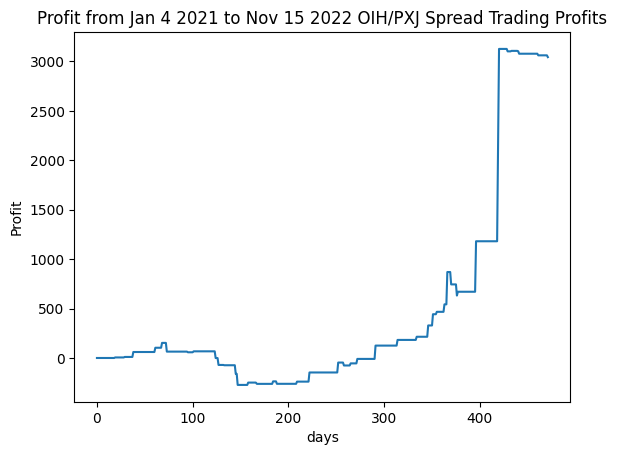

In [951]:
plt.plot(PXJ_OIH['Total'])
plt.title('Profit from Jan 4 2021 to Nov 15 2022 OIH/PXJ Spread Trading Profits')
plt.ylabel('Profit')
plt.xlabel('days')

Profit for FTSL/SMH

Text(0.5, 0, 'days')

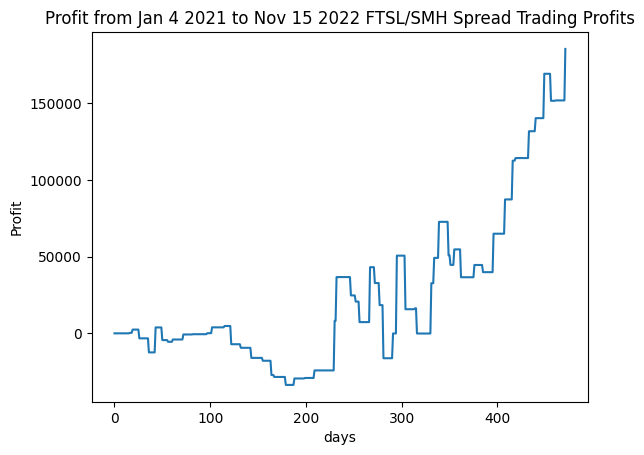

In [952]:
plt.plot(FTSL_SMH['Total'])
plt.title('Profit from Jan 4 2021 to Nov 15 2022 FTSL/SMH Spread Trading Profits')
plt.ylabel('Profit')
plt.xlabel('days')

It is very noticable that the strategy made far more money in the FTSL/SMH spread trade than the PXJ/OIH, but thats mainly due to the fact that PXJ has way less daily volume and theirfore our capital for FTSL/SMH is far greater. The overall percent return on FTSL/SMH is .17% and for PXJ/OIH its .035% return.


To show what other parameters may look like, and why I settled on mine I will show some plots of this strategy being utilized with different parameters.

stop loss at 2022-01-27 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss at 2022-06-13 00:00:00
stop loss at 2022-09-21 00:00:00
stop loss at 2022-10-11 00:00:00
Total Return on Capital = -0.0546375271412991
stop loss at 2022-01-21 00:00:00
stop loss at 2022-03-07 00:00:00
stop loss at 2022-04-11 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss at 2022-09-22 00:00:00
stop loss at 2022-10-14 00:00:00
Total Return on Capital = -0.10757820735989299


Text(0, 0.5, 'profit')

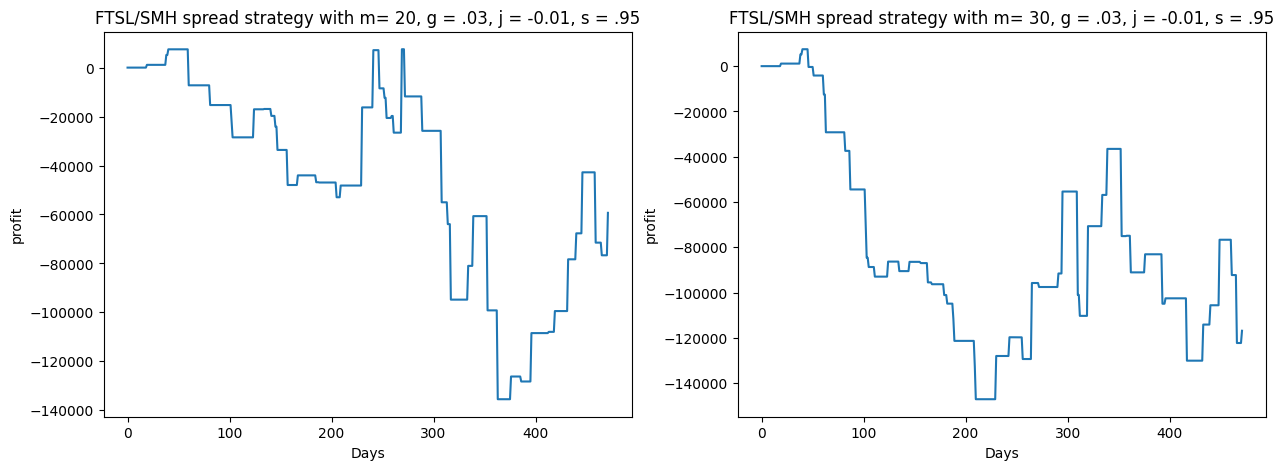

In [953]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
m20 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 20, .03, -.01, .95)
m30 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 30, .03, -.01, .95)
ax1.plot(m20['Total'])
ax1.set_title('FTSL/SMH spread strategy with m= 20, g = .03, j = -0.01, s = .95')
ax1.set_xlabel('Days')
ax1.set_ylabel('profit')
ax2.plot(m30['Total'])
ax2.set_title('FTSL/SMH spread strategy with m= 30, g = .03, j = -0.01, s = .95')
ax2.set_xlabel('Days')
ax2.set_ylabel('profit')


As seen, using a higher M is resulting in very negative profit for me, hence why I chose a smaller moving average of m = 10.

Lets also analyze lower and higher j and g values with a 10 day average

stop loss at 2022-01-27 00:00:00
stop loss at 2022-02-23 00:00:00
stop loss at 2022-03-14 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss at 2022-09-21 00:00:00
stop loss at 2022-10-11 00:00:00
Total Return on Capital = 0.1274719534970714
stop loss at 2021-05-12 00:00:00
stop loss at 2022-03-14 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss at 2022-09-22 00:00:00
stop loss at 2022-10-14 00:00:00
Total Return on Capital = -0.03425486621562168


Text(0, 0.5, 'profit')

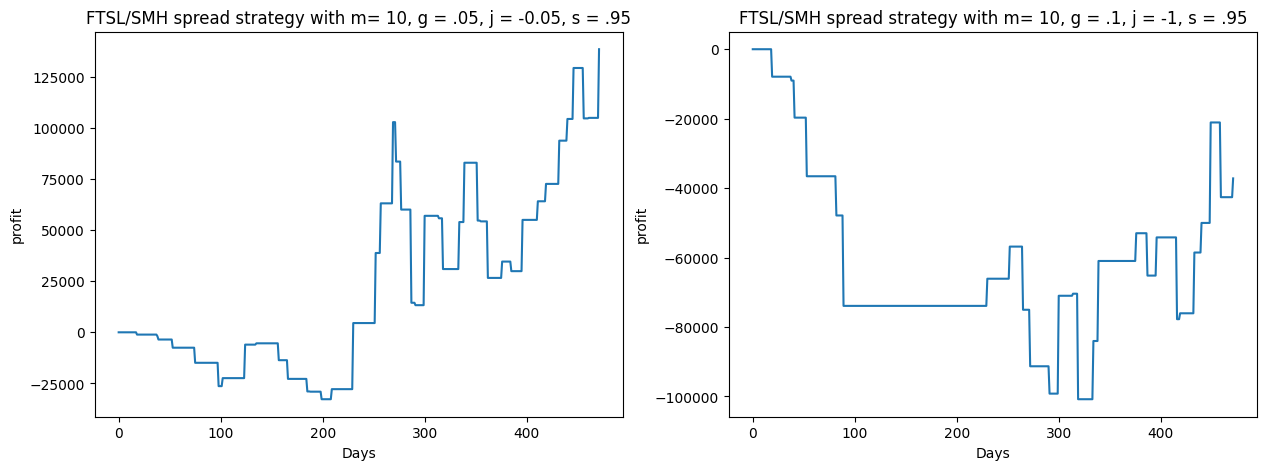

In [954]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
m20 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 10, .05, -.05, .95)
m30 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 10, .1, -.1, .95)
ax1.plot(m20['Total'])
ax1.set_title('FTSL/SMH spread strategy with m= 10, g = .05, j = -0.05, s = .95')
ax1.set_xlabel('Days')
ax1.set_ylabel('profit')
ax2.plot(m30['Total'])
ax2.set_title('FTSL/SMH spread strategy with m= 10, g = .1, j = -1, s = .95')
ax2.set_xlabel('Days')
ax2.set_ylabel('profit')

While the first one yields profit, it is less than when I used a smaller absolute value of j and g. As j and g get up to .1 and -.1, I start yielding negative profit.

Now lets look at a super high s (meaning we always close our trades the next day practically), and a super low s (meaning we basically don't have a stop loss)

stop loss at 2021-01-27 00:00:00
stop loss at 2021-02-18 00:00:00
stop loss at 2021-02-22 00:00:00
stop loss at 2021-03-03 00:00:00
stop loss at 2021-03-08 00:00:00
stop loss at 2021-03-10 00:00:00
stop loss at 2021-03-23 00:00:00
stop loss at 2021-04-14 00:00:00
stop loss at 2021-05-04 00:00:00
stop loss at 2021-05-12 00:00:00
stop loss at 2021-08-12 00:00:00
stop loss at 2021-09-08 00:00:00
stop loss at 2021-09-29 00:00:00
stop loss at 2021-10-04 00:00:00
stop loss at 2021-10-12 00:00:00
stop loss at 2022-01-19 00:00:00
stop loss at 2022-01-21 00:00:00
stop loss at 2022-01-25 00:00:00
stop loss at 2022-01-27 00:00:00
stop loss at 2022-02-10 00:00:00
stop loss at 2022-03-04 00:00:00
stop loss at 2022-03-14 00:00:00
stop loss at 2022-03-23 00:00:00
stop loss at 2022-03-25 00:00:00
stop loss at 2022-03-30 00:00:00
stop loss at 2022-04-08 00:00:00
stop loss at 2022-04-14 00:00:00
stop loss at 2022-04-21 00:00:00
stop loss at 2022-04-26 00:00:00
stop loss at 2022-05-09 00:00:00
stop loss 

Text(0, 0.5, 'profit')

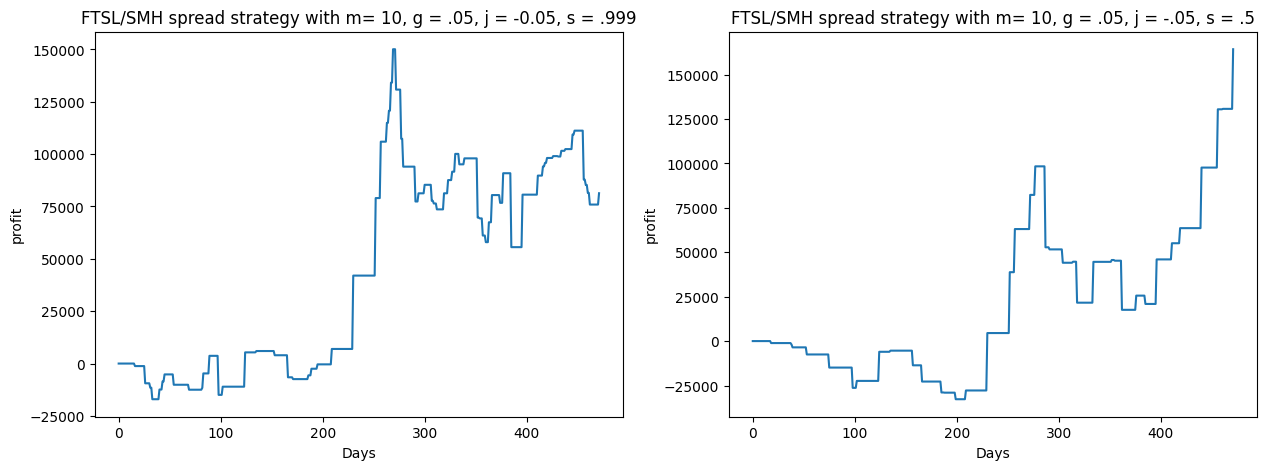

In [955]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
m20 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 10, .05, -.05, .999)
m30 = FTSL_SMH = spread_reversion_strategy(FTSL, SMH, 10, .05, -.05, .5)
ax1.plot(m20['Total'])
ax1.set_title('FTSL/SMH spread strategy with m= 10, g = .05, j = -0.05, s = .999')
ax1.set_xlabel('Days')
ax1.set_ylabel('profit')
ax2.plot(m30['Total'])
ax2.set_title('FTSL/SMH spread strategy with m= 10, g = .05, j = -.05, s = .5')
ax2.set_xlabel('Days')
ax2.set_ylabel('profit')

Both of these yield profit, but slightly less than a .95S. It is also noticable that we are trading more frequently when s = .999 because we are always closing our positions and less frequently for s = .5 because we never hit our stop loss and only trade when the spread changes below or above g and j. 

Now to compare with Fama French. Since the returns of the fama french factors are way larger than my strategy, I graphed them on the same plot but with a different y axis to compare the shape of the two graphs.

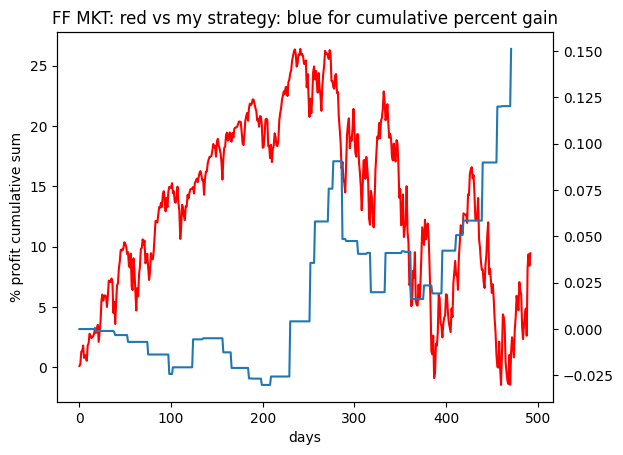

In [956]:
fig,ax = plt.subplots()
ax.plot(ff['Mkt-RF'].cumsum(),
        color="red")
ax.set_xlabel('days')
ax.set_ylabel('% profit cumulative sum')
ax.set_title('FF MKT: red vs my strategy: blue for cumulative percent gain')

ax2=ax.twinx()
ax2.plot(FTSL_SMH['percent gain'].cumsum())


It is noticable that My returns are in fact potentially negatively correlated to the MKT factor as at the end the MKT factor starts yielding very negative returns while mine starts becoming quite positive.

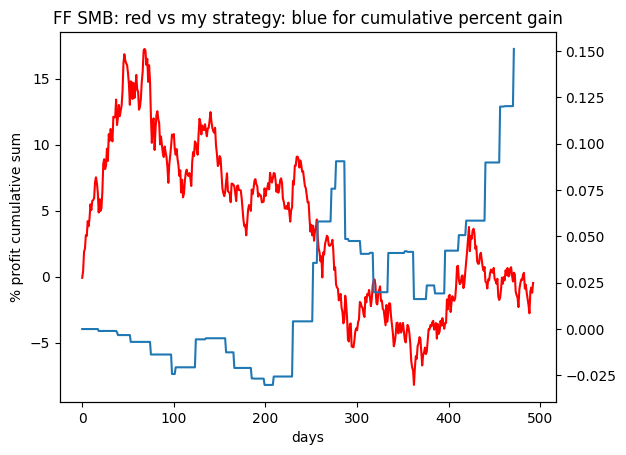

In [957]:
fig,ax = plt.subplots()
ax.plot(ff['SMB'].cumsum(),
        color="red")
ax.set_xlabel('days')
ax.set_ylabel('% profit cumulative sum')
ax.set_title('FF SMB: red vs my strategy: blue for cumulative percent gain')

ax2=ax.twinx()
ax2.plot(FTSL_SMH['percent gain'].cumsum())

Same with the SMB size factor, potentially a somewhat negative correlation.

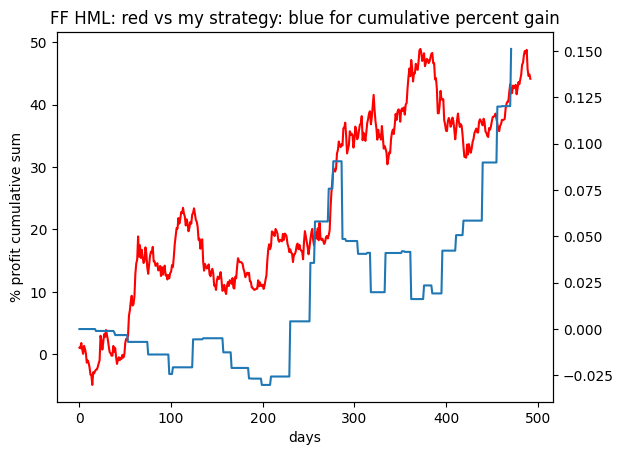

In [958]:
fig,ax = plt.subplots()
ax.plot(ff['HML'].cumsum(),
        color="red")
ax.set_xlabel('days')
ax.set_ylabel('% profit cumulative sum')
ax.set_title('FF HML: red vs my strategy: blue for cumulative percent gain')

ax2=ax.twinx()
ax2.plot(FTSL_SMH['percent gain'].cumsum())

For HMB, the value factor, these returns seem quite correlated.

CONCLUSIONS

While this strategy doesn't seem to make large percent profit, it is able to achieve returns quite uncorrelated to the market. This could be important for hedging, but likely, this strategy isn't making enough money to be utilized effectively. Also, since my two ETFs weren't the most correlated, there were many parameters that would lead to significant losses in my backtesting, and I believe that in the future, using the exact parameters that I obtained may not lead to profit. In my opinion, it would be way better to spread trade with ETF's that were almost identical.